Übung 3.3 a)

Es sollen der kostenminimale Kraftwerkseinsatz sowie die Gesamtkosten und -emissionen unter Berücksichtigung von Erneuerbaren Energien und unter Einbezug des Speichers berechnet werden.

Model unknown

  Variables:
    x : Size=72, Index={Kohle, GuD, Gasturbine}*{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}
        Key                : Lower : Value              : Upper : Fixed : Stale : Domain
         ('Gasturbine', 0) :     0 :                0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 1) :     0 :                0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 2) :     0 :                0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 3) :     0 :                0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 4) :     0 :                0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 5) :     0 :                0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 6) :     0 :                0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 7) :     0 :                0.0

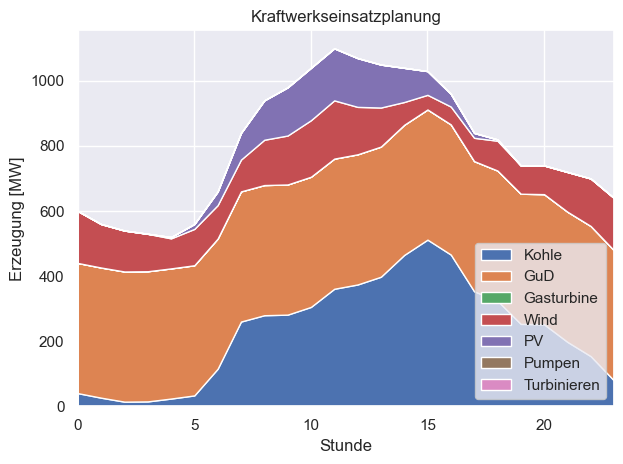

In [1]:

#Einlesen der Module
from pyomo.environ import *
import pyomo.environ as pyo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


T = 24
timesteps = np.arange(T)

#Zertifikatspreis
c_CO2 = 80 # EUR/tCO2

# Marginal costs der thermischen Kraftwerke berechnen
# Werte wurden auf die Angabe angepasst
thermalPlant = ['Kohle', 'GuD', 'Gasturbine']
power = {'Kohle': 600,
         'GuD': 400,
         'Gasturbine': 300} # MW
efficiency = {'Kohle': 0.41,
         'GuD': 0.58,
         'Gasturbine': 0.4} 
fuel_price = {'Kohle': 10,
         'GuD': 30,
         'Gasturbine': 30} # EUR/MWhprim
emission_factor = {'Kohle': 0.35,
         'GuD': 0.2,
         'Gasturbine': 0.2} # tCO2/MWhprim
MC = {} # marginal costs in EUR/MWh
emissions = {} # emissions in tCO2/MWh
for n in thermalPlant:
    MC[n] = (fuel_price[n] + emission_factor[n] * c_CO2) / efficiency[n]
    emissions[n] = emission_factor[n] / efficiency[n]
    
# Daten laden, PV und Wind laden
df = pd.read_excel('Last_PV_Wind.xlsx')
wind = df['Wind 300 MW']
PV = df['PV 200 MW Sommer']
load = df['Last Sommer [MW]']

# Pyomo Modell aufstellen, es wurden Modelle für den Speicher hinzugefügt
# model.turb und model.pump für die Menge die gepumpt/turbiniert wird
# model.pump_dec sowie model.turb_dec stellen binäre decision Variablen dar, es wird entweder gepumpt/turbiniert oder nicht
# model.cap für die Menge die im Speicher drinnen ist

model = ConcreteModel()

model.x = Var(thermalPlant, timesteps, within = NonNegativeReals)
model.pump = Var(timesteps, within = NonNegativeReals) #Menge
model.turb = Var(timesteps, within = NonNegativeReals) #Menge
model.cap = Var(timesteps, within = NonNegativeReals)#wie viel drin ist

# Zielfunktion, Kosten sollen minimiert werden
#dazu werden die Grenzkosten aller Kraftwerke zu jedem timestep summiert.
model.obj = Objective(
    expr = sum(model.x[n,t] * MC[n] for n in thermalPlant for t in timesteps), 
    sense= minimize)

#Nebenbedingungen bezüglich Leistung
def power_constraint_rule(model, n, t):    
   return model.x[n,t] <= power[n]
model.power_con = Constraint(thermalPlant, 
                             timesteps, 
                             rule = power_constraint_rule)

#max Speicherkapazität darf nicht überschritten werden
def max_cap_constraint_rule(model, t):
    return model.cap[t] <= 600
model.max_cap = Constraint(timesteps,
                               rule = max_cap_constraint_rule)

#max Pumpkapazität darf nicht überschritten werden
def max_pump_constraint_rule(model, t):
    return model.pump[t] <= 200
model.max_pump = Constraint(timesteps,
                               rule = max_pump_constraint_rule)

#max Turbinierkapazität darf nicht überschritten werden
def max_turb_constraint_rule(model, t):
    return model.turb[t] <= 200
model.max_turb = Constraint(timesteps,
                               rule = max_turb_constraint_rule)

#es darf nicht mehr turbiniert werden als zur Verfügung steht
def max_turb1_constraint_rule(model, t):
    return model.turb[t] <= model.cap[t]/0.9
model.max_turb1 = Constraint(timesteps,
                               rule = max_turb1_constraint_rule)

#Kapziät bei t=23 muss gleich sein wie t=0
def capa_stand_constraint_rule(model, t):
    return model.cap[0] == model.cap[23]
model.cap1 = Constraint(timesteps,
                               rule = capa_stand_constraint_rule)

#Beschreibung der Auffüllung und Entleerung des Speichers 
def capa_constraint_rule(model, t):
    if t == 0:
       return model.cap[t] == 0
    else:
        return model.cap[t] <= model.cap[t-1] + model.pump[t]*0.9 - model.turb[t]/ 0.9   
model.capa = Constraint(timesteps, 
                           rule = capa_constraint_rule)

#Erzeugung und Last müssen sich unter Berücksichtigung des Speichers decken
def load_constraint_rule(model, t):
   return (sum(model.x[n,t] for n in thermalPlant)) + wind.loc[t] + PV.loc[t] + model.turb[t] - model.pump[t] == load.loc[t] 
model.load_con = Constraint(timesteps, 
                            rule = load_constraint_rule)

###Schattenvariable
model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT_EXPORT)

opt = SolverFactory('gurobi')
opt_success = opt.solve(model)

model.display()

# get values of optimization variables
PowerThermal = pd.DataFrame(index = timesteps, columns = thermalPlant)
for t in timesteps:
    for n in thermalPlant:
        PowerThermal.loc[t, n] = model.x[n,t].value

print()
totalMinCost = model.obj()
print("Gesamtkosten der Stromversorgung:", totalMinCost, "EUR" )
totalEmissions = sum(model.x[n,t].value * emissions[n] for n in thermalPlant for t in timesteps)
print("Gesamte CO2 Emissionen", totalEmissions, "tCO2" )


# plot
values = pd.DataFrame(index=timesteps, columns=['pump','turb'])
for t in timesteps:
    values.loc[t,'pump'] = model.pump[t].value
    values.loc[t,'turb'] = model.turb[t].value

sns.set()
labels = ['Kohle', 'GuD', 'Gasturbine','Wind', 'PV','Pumpen','Turbinieren']

fig, ax = plt.subplots()

ax.stackplot(timesteps, 
            PowerThermal.to_numpy(dtype = float).transpose(),
             wind, PV,values['pump'].to_numpy(dtype = float).transpose(),
             values['turb'].to_numpy(dtype = float).transpose(),
             labels=labels)
ax.set_title('Kraftwerkseinsatzplanung')
ax.legend(loc='lower right')
ax.set_ylabel('Erzeugung [MW]')
ax.set_xlabel('Stunde')
ax.set_xlim(xmin=timesteps[0], xmax=timesteps[-1])
fig.tight_layout()



3.3 b) 

Auf das verändern der Zielfunktion verglichen mit Beispiel 3.2 wurde verzichtet, da der Speicher in den Nebenbedingungen berücksichtigt wird. 

Zielfunktion:
$$\underset{x}{min} \sum\limits _{thermische Kraftwerke} Leistung_{[MW]}* Grenzkosten_{[EUR/MWh]} $$

$$ \text{c1:} \quad P_{Kohle} \leq 600 $$

$$ \text{c2:} \quad P_{GuD} \leq 400 $$

$$ \text{c3:} \quad P_{Gas} \leq 300 $$

$$ \text{c4:} \quad P_{Wind} \leq 300 $$

$$ \text{c5:} \quad P_{PV} \leq 200 $$

$$ \text{c6:} \quad C_{Speicher} \leq 600$$

$$ \text{c7:} \quad C_{Pumpe} \leq 200$$

$$ \text{c8:} \quad C_{Turbine} \leq 200$$

$$ \text{c9:} \quad P_{Turbine}(t) \leq C_{Speicher}(t)/\eta$$

$$ \text{c10:} \quad C_{Speicher}(0) = C_{Speicher}(23)$$

$$ \text{c11:} \quad C_{Speicher}(0) = 0$$

$$ \text{c12:} \quad C_{Speicher}(t) \leq C_{Speicher}(t-1) + P_{Pumpe}*\eta - P_{Turbine}/\eta$$

$$ \text{c13:} \quad P_{Kohle} + P_{GuD} + P_{Gas} + P_{Wind} +P_{PV} +  P_{Turbine} - P_{Pumpe} = P_{Last} $$



3.3 c)

In diesem Szenario ist der Speicher nicht aktiv. Dies lässt sich dadurch begründen, dass zu die günstigen ernerbaren Energiequellen als erstes verbraucht werden, um die Last zu decken. Die verbleibende Last wird mit (in diesem Szenario am nächstgünstigsten) Kohle- und GuD-Kraftwerken gedeckt. Diese sind jedoch den gesamten Tag aktiv und werden nicht komplett zu- oder weggeschaltet. Daher gibt es keinen Anreiz, den Speicher zu verwenden, da dies die Gesamtkosten nicht verändern würde. Dadurch bleiben auch die CO2-Emissionen unverändert. 

Erst wenn die Last nicht mehr durch Kohle, GuD und Erneuerbare gedeckt werden könnte, wäre ein Anreiz gegeben, den Speicher zu verwenden (zB würde man P_Kohle auf 300MW herabsetzen).
Gleiches wäre zu erkennen, würde man in diesem Szenario die Zertifikatspreise herabsetzen (etwa auf 30). Dann ist durchaus zu erkennen, dass durch Benutzen des Speichers zu gewissen Zeitpunkten das Zuschalten von teureren Kraftwerken vermieden werden kann, wodurch die Gesamtkosten reduziert werden können.


3.3 d)

Durch das Nichtverwenden des Speichers bleiben die stündlichen Strompreise im Vergleich zu Punkt 3.2 unverändert.

3.3 e)

Durch den Einsatz von Erneuerbare Energiequellen konnten wegen deren Grenzkosten von 0 die Einsatzkosten in Punkt 3.2 im Vergleich zu 3.1 gesenkt werden. Wegen deren fehlenden CO2 Emissionen konnten auch die Gesamtemissionen reduziert werden. Da der Speicher in Punkt 3.3 nicht genutzt wird, bleiben die Kosten und Emissionen im Vergleich zu Punkt 3.2 unverändet.